<h1> MNIST in Pytorch <h1>

In [243]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [219]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5))])
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root = './data', train = True, transform = transform, download = True)
test_dataset = datasets.MNIST(root = './data', train = False, transform = transform, download = True)
train_loader = DataLoader(train_dataset, batch_size = 500, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle = False)

In [181]:
len(train_loader.dataset)

60000

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# ohe = OneHotEncoder(sparse_output=False, categories='auto') 
# ohe.fit_transform(np.arange(10).reshape(-1,1))

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
# Lets Create our NN

class MNIST_NN(nn.Module):

    def __init__(self):
        super().__init__()

        #Convolutional Layers
        self.conv1 = nn.Conv2d(1,10,5,1)
        self.conv2 = nn.Conv2d(10,20,5,1)

        #Fully connected Layers
        self.fc1 = nn.Linear(320, 128)
        self.fc2 = nn.Linear(128 , 64)
        self.fc3 = nn.Linear(64 , 10)

    def forward(self,x):

        #Convolutional Layers and Pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)

        x = x.view(-1,320)

        #Fully connected Layers

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.log_softmax(x,dim = 1)

In [140]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [141]:
torch.manual_seed(41)
model = MNIST_NN()
model = model.to(device)
model

MNIST_NN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [142]:
optimizer = optim.Adam(model.parameters(),lr =0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
def save_checkpoint(model,optimzers,epoch,best_acc):
    state = {
        'epoch' : epoch + 1,
        'model' : model.state_dict(),
        'best accuracy' : best_acc,
        'optimizers' : optimzers.state_dict(),
        'comments' : 'Best_Accuracy',
        
    }

    torch.save(state,'best.pth.tar')

def last_checkpoint(model,optimizers):
    state = {
        'model' : model.state_dict(),
        'optimizers' : optimizers.state_dict(),        
    }
    torch.save(state,'last.pth.tar')

In [ ]:
def train_nn(epochs):

    model.train()

    test_losses = []
    train_losses = []
    test_crr = 0
    train_crr = 0

    last = 0
    best_acc = 0

    for epoch in range(epochs):
         
        last += 1
        print(f"Epoch : {epoch+1}")


        for count, (X_train,y_train) in enumerate(train_loader):
            
            X_train,y_train = X_train.to(device), y_train.to(device)      
            optimizer.zero_grad()

            y_pred = model(X_train)

            loss = criterion(y_pred, y_train)

            train_losses.append(loss.detach().numpy())

            predicted = torch.max(y_pred.data, 1)[1]
            train_crr += (predicted == y_train).sum().item()
            
            loss.backward()
            optimizer.step()

            if count %60 == 0 :
                print(f"Train dataset: Epoch {epoch+1}, {count * len(X_train)} / {len(train_loader.dataset)} , Accuracy {100. * count / len(train_loader): .0f}% , Loss {loss:.6f}")    


        with torch.no_grad():

            t_loss = 0
            test_crr = 0

            model.eval()

            for k, (X_test,y_test) in enumerate(test_loader):

                X_test,y_test = X_test.to(device), y_test.to(device)
        
                y_eval = model(X_test)

                predicted = torch.max(y_eval.data, 1)[1] # Adding up correct predictions
                test_crr += (predicted == y_test).sum().item() # T=1 F=0 and sum away


            t_loss = criterion(y_eval, y_test)
            test_losses.append(t_loss.detach().numpy())


        eval_acc = 100.00 * (test_crr/k)

        print(f"Test dataset: Accuracy {test_crr} / {len(test_loader.dataset)} , Accuracy {100. * test_crr / len(test_loader.dataset): .0f}% , Loss {t_loss:.6f}")


        if eval_acc > best_acc:
            best_acc = eval_acc
            save_checkpoint(model,optimizer,epoch,best_acc)
            
        if last == epochs:
            last_checkpoint(model,optimizer)



In [261]:
train_nn(10)

Epoch : 1
Train dataset: Epoch 0, 0 / 60000 , Accuracy  0% , Loss 0.000005
Train dataset: Epoch 0, 30000 / 60000 , Accuracy  50% , Loss 0.000027
Test dataset: Accuracy 9921 / 10000 , Accuracy  99% , Loss 0.045931
Epoch : 2
Train dataset: Epoch 1, 0 / 60000 , Accuracy  0% , Loss 0.000093
Train dataset: Epoch 1, 30000 / 60000 , Accuracy  50% , Loss 0.000055
Test dataset: Accuracy 9921 / 10000 , Accuracy  99% , Loss 0.046417
Epoch : 3
Train dataset: Epoch 2, 0 / 60000 , Accuracy  0% , Loss 0.000024
Train dataset: Epoch 2, 30000 / 60000 , Accuracy  50% , Loss 0.000007
Test dataset: Accuracy 9922 / 10000 , Accuracy  99% , Loss 0.047141
Epoch : 4
Train dataset: Epoch 3, 0 / 60000 , Accuracy  0% , Loss 0.000024
Train dataset: Epoch 3, 30000 / 60000 , Accuracy  50% , Loss 0.000023
Test dataset: Accuracy 9922 / 10000 , Accuracy  99% , Loss 0.047507
Epoch : 5
Train dataset: Epoch 4, 0 / 60000 , Accuracy  0% , Loss 0.000059
Train dataset: Epoch 4, 30000 / 60000 , Accuracy  50% , Loss 0.000026
Tes

In [146]:
# plt.plot([t/600 for t in train_crr], label = "Train Correct")
# plt.plot([t/100 for t in test_crr], label = "Test Correct")
# plt.legend()

In [221]:
test_data_new = DataLoader(test_dataset, batch_size=10000, shuffle= False)

with torch.no_grad():
    correct = 0 
    for l,(X_test,y_test) in enumerate(test_data_new):
        y_eval = model(X_test)
        predicted = torch.max(y_eval,1)[1]
        correct += (predicted == y_test ).sum()

In [222]:
correct

tensor(9920)

2


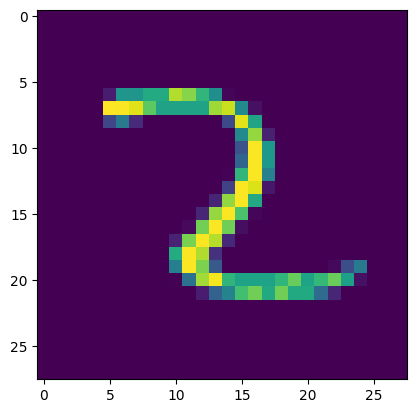

In [223]:
td= test_dataset[2500]
plt.imshow(td[0].reshape(28,28))
print(td[1])

In [ ]:
model.eval()

MNIST_NN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)